# Pathological Noise Model Example

In [1]:
import warnings
warnings.filterwarnings("ignore") # bad practice, but pystan has a bunch of annoying warnings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pystan as ps
import stan_utility
import numpy as np
import scipy.stats as st
import utils as su
import seaborn as sbn

su.overwrite = True

## Data Generation

Load in the simulated survival probabilities from Mathematica's output (`survival-distributions.nb`), and use it to simulate some bernoulli trials.

In [2]:
rbd = su.RBSimData('../data/pathological_model_survivals.h5')
multimodal_survivals = rbd.survival_data[:,0,:,0]

mlist = rbd.sequence_lengths
Nm = mlist.shape[0]
Nbin = 50
Nsamp = 30

datavals = np.empty((Nm, Nsamp), dtype='int')
for idx_m, m in enumerate(mlist):

    p = multimodal_survivals[idx_m,:Nsamp]
    datavals[idx_m,:] = np.random.binomial(Nbin,p)
      
data = dict(
    Nm=Nm, Nsamp=Nsamp, Nbin=Nbin, Nc=20,
    m=mlist,
    Q=datavals,
    p_est = .5, A_est = .5, B_est = .5,
    p_t = .5, A_t = .5, B_t = .5,
    d=2
)

## Dirichlet Process Stan Model

Load the CDPBM stan model. We use a wrapping class that caches these compiled models to disk, so the first time it loads will take the longest.

In [3]:
model_dp = su.StanModelFactory('./stan/rb-dp.stan').model

Now fit the data with this model:

In [4]:
fit_dp = model_dp.sampling(data=data, iter=2000, chains=4, control=dict(adapt_delta=0.8))

Check that we don't have too many divergent particles:

In [5]:
stan_utility.check_div(fit_dp)

0.0 of 4000 iterations ended with a divergence (0.0%)


In [6]:
def survival_dist_plot(fit, m=100, surv_color='b', surv_hatch=''):
    data = fit.data
    idx_m = int(np.arange(data['Nm'])[data['m'] == m])

    skip = 10
    w = fit.extract()['w'][::skip,idx_m,np.newaxis,:]
    nu = fit.extract()['nu'][::skip,idx_m,np.newaxis,:]
    r = fit.extract()['r'][::skip,idx_m,np.newaxis,:]
    a = 1 / (r - r * nu) - nu
    b = 1 / (r * nu) - 1 + nu

    x_plot = np.linspace(0,1,200)
    post_pmfs = np.sum(w * st.beta.pdf(np.atleast_3d(x_plot), a, b), axis=2)
    post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)
    plt.fill_between(x_plot, post_pmf_low, post_pmf_high, color='gray', alpha=0.5, zorder=50, label='%95 credible region')
    plt.plot(x_plot, post_pmfs.mean(axis=0), lw=2, c='k', label='Posterior expected \nsurvival distribution')

    survivals = rbd.survival_data[idx_m,0,:,0]
    plt.hist(
        data['Q'][idx_m,:] / float(data['Nbin']), 
        normed=True, color='violet', 
        bins=50, range=(0,1), 
        alpha=0.5, 
        label='Normalized Data, Q/N'
    )
    plt.hist(
        survivals, 
        normed=True, 
        bins=50, 
        range=(0,1), 
        alpha=0.8, 
        color=surv_color, hatch=surv_hatch, 
        linewidth=0, 
        edgecolor=su.lighten_color(surv_color,0.7),
        label='Survival Distribution'
    )


    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,3,1,2]
    plt.ylim([0, 1.0 * plt.gca().get_ylim()[1]])
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1)
    plt.yticks([])
    plt.xlabel('Survival Probability')
    
    label_loc=[0.05,0.9]
    plt.gca().text(label_loc[0], label_loc[1], 'M={}'.format(m),
        transform = plt.gca().transAxes, va='center', ha='left'
    )

Overwriting ../fig/pathological-survival-distributions.png
Overwriting ../fig/pathological-survival-distributions.pdf


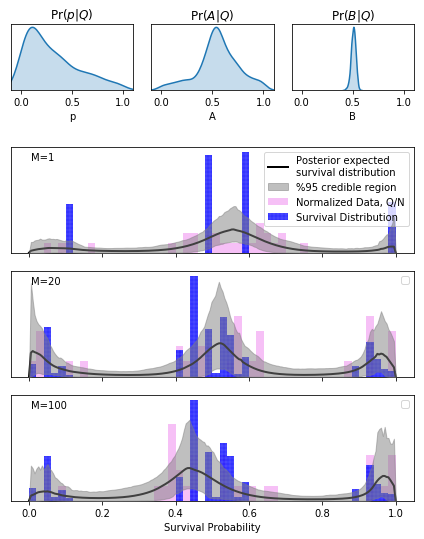

In [7]:
mvals = [1,20,100]
n_m = len(mvals)


fig = plt.figure(figsize=(6,1.9*(n_m+1)))
gs1 = gridspec.GridSpec(1,3, top=1, bottom=1-0.8/(n_m+1), right=1, left=0)
gs2 = gridspec.GridSpec(n_m,1, top=1-1.1/(n_m+1), bottom=0, right=1, left=0)


params = ['p', 'A', 'B']
for idx_param, param in enumerate(params):
    plt.sca(plt.subplot(gs1[0,idx_param]))
    sbn.kdeplot(fit_dp.extract()[param][::10], shade=True)
    plt.yticks([])
    plt.xlim([-0.1,1.1])
    plt.xlabel(param)
    plt.title('$\operatorname{{Pr}}({{{}}}|Q)$'.format(param))

for idx_m, m in enumerate(mvals):
    plt.sca(plt.subplot(gs2[idx_m,0]))
    survival_dist_plot(fit_dp, m=m, surv_hatch='+++')
    if idx_m != 0:
        plt.legend([])
    if idx_m < n_m-1:
        plt.gca().set_xticklabels([])
        plt.xlabel('')
        
gs1.tight_layout(fig, rect=(0,1-1./(n_m+1),1,1))
gs2.tight_layout(fig, rect=(0,0,1,1-1./(n_m+1)))
        
su.export_figure(fig, 'pathological-survival-distributions')